In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array , load_img
from keras.models import load_model
import scipy
from keras.utils import to_categorical
import numpy as np
import cv2
import requests
from keras.utils import plot_model
from tensorflow.keras.layers import *
import datetime
import pickle
import warnings
warnings.filterwarnings("ignore")


2024-04-10 01:03:34.473809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 01:03:34.473932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 01:03:34.622022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install split-folders

In [3]:
import splitfolders
splitfolders.ratio("/kaggle/input/face-mask-detection/Dataset", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 8982 files [01:24, 105.72 files/s]


In [4]:
train_path='/kaggle/working/output/train'
validation_path='/kaggle/working/output/val'
test_path='/kaggle/working/output/test'
picture_size=48 # we will use the image size=48 in DNN  and nn on grayscaled images to compare performance between DNN and CNN
batch_size=128
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Load train, validation, and test datasets
train_data_set = datagen.flow_from_directory(
    directory=train_path,
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['mask_weared_incorrect','without_mask','with_mask'],
    color_mode='grayscale'
)

validation_data_set = datagen.flow_from_directory(
    directory=validation_path,
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    classes=['mask_weared_incorrect','without_mask','with_mask'],
    class_mode='categorical',
    color_mode='grayscale'
)

test_data_set = datagen.flow_from_directory(
    directory=test_path,
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    classes=['mask_weared_incorrect','without_mask','with_mask'],

)

Found 7185 images belonging to 3 classes.
Found 897 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


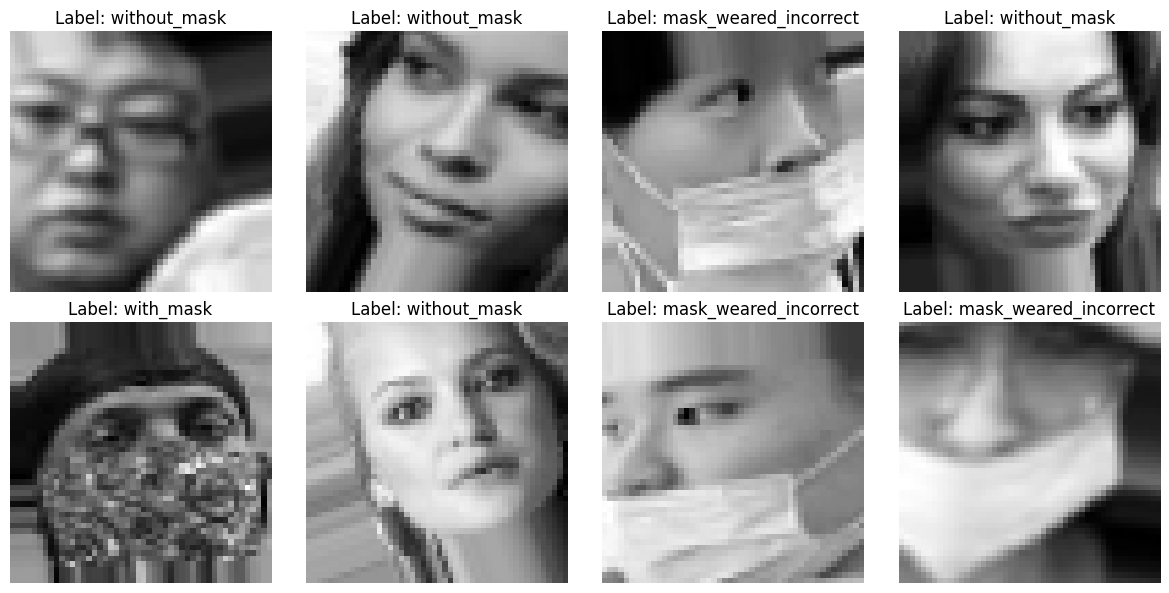

In [5]:
def plot_images_with_labels(data_set, class_labels, num_images=8):
    images, labels = next(data_set)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].squeeze(),cmap='gray')
        true_label_index = labels[i].argmax()
        true_label = class_labels[true_label_index]
        plt.title(f"Label: {true_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
class_labels = ["mask_weared_incorrect", "without_mask", "with_mask"]
plot_images_with_labels(train_data_set, class_labels)


In [12]:
!pip install -U memset

ERROR: Could not find a version that satisfies the requirement memset (from versions: none)
ERROR: No matching distribution found for memset


In [14]:
model=tf.keras.Sequential([
    Input(shape = (48, 48, 1)),
    Flatten(),
    Dense(16,activation='relu',),
    Dense(32,activation='relu'),
    Dense(64,activation='relu'),
    Dense(128,activation='relu'),
    Dense(256,activation='relu'),
    Dense(512,activation='relu'),
    Dropout(0.255),
    Dense(1024,activation='relu'),
    Dropout(0.255),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(3,activation='softmax'),
])
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
Early_Stopping=tf.keras.callbacks.EarlyStopping(patience=20,verbose=1)
history=model.fit(train_data_set,epochs=100,validation_data=validation_data_set,batch_size=128,callbacks=[tensorboard_callback,Early_Stopping])

Epoch 1/100
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10:31 11s/step - accuracy: 0.3438 - loss: 1.0981

W0000 00:00:1712712454.129495     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 309ms/step - accuracy: 0.3971 - loss: 1.0542 - val_accuracy: 0.5496 - val_loss: 0.9391
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.5499 - loss: 0.8806 - val_accuracy: 0.5340 - val_loss: 0.8710
Epoch 3/100
 7/57 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.5529 - loss: 0.8695

KeyboardInterrupt: 

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        36,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,313,147 (16.45 MB)

 Trainable params: 1,437,715 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,875,432 (10.97 MB)

In [8]:
model.save('/kaggle/working/mask_detection_model_DNN.h5')

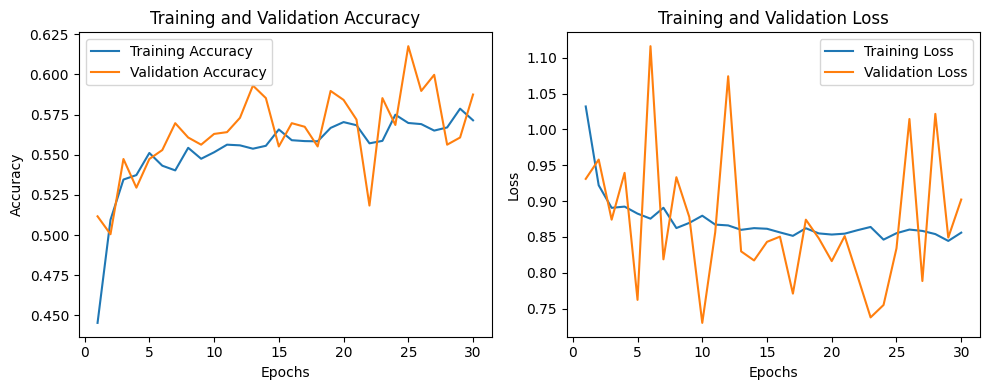

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'history' contains your training history
# Call the function to plot the training history
plot_training_history(history)


In [10]:
model.evaluate(test_data_set)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.5652 - loss: 0.8270


[0.839867115020752, 0.554444432258606]

In [ ]:
!pip install -U keras tensorflow tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 589.8/589.8 MB 38.1 MB/s eta 0:00:0100:01